In [ ]:
#Importing the required Libraries
# !pip install
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# from ydata_profiling import ProfileReport
pd.set_option('display.max_columns',None)
# from pydantic_settings import BaseSettings # NEW
warnings.filterwarnings('ignore')

In [ ]:
!gdown 1BhDQbXywCjAzF9fm74HClcN-HYECP4qs
!gdown 12iOMfz0OqH4x-gyOI1egRCNEwUzZiPry
!gdown 1P0Ha0l0fVgcmK8xNF8FQSqx2ECTd9Uu8

Downloading...
From: https://drive.google.com/uc?id=1BhDQbXywCjAzF9fm74HClcN-HYECP4qs
To: /content/payment.csv
100% 53.6M/53.6M [00:00<00:00, 59.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=12iOMfz0OqH4x-gyOI1egRCNEwUzZiPry
From (redirected): https://drive.google.com/uc?id=12iOMfz0OqH4x-gyOI1egRCNEwUzZiPry&confirm=t&uuid=acd3d250-24ed-4638-b68b-18530d8a3471
To: /content/loan.csv
100% 110M/110M [00:00<00:00, 171MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1P0Ha0l0fVgcmK8xNF8FQSqx2ECTd9Uu8
To: /content/clarity_underwriting_variables.csv
100% 15.1M/15.1M [00:00<00:00, 106MB/s] 


In [ ]:
#Loading the data
loan_df=pd.read_csv('loan.csv',parse_dates=['applicationDate', 'originatedDate'])
payment_df=pd.read_csv('payment.csv',parse_dates=['paymentDate'])
clarity_df=pd.read_csv('clarity_underwriting_variables.csv')

print(f"The available loan data has {loan_df.shape[0]} rows & {loan_df.shape[1]} columns")
print(f"The available loan data has {payment_df.shape[0]} rows & {payment_df.shape[1]} columns")
print(f"The available loan data has {clarity_df.shape[0]} rows & {clarity_df.shape[1]} columns")

The available loan data has 577682 rows & 19 columns
The available loan data has 689364 rows & 9 columns
The available loan data has 49752 rows & 54 columns


Credit risk refers to the potential for a borrower to default on a loan, posing a financial risk to the lender. In the context of MoneyLion, they act as the lender while their customers, who could range from blue-collar workers to large corporations, are the borrowers. For example, if I were to take out a loan of RM100,000 with an 8-year term at an 8% interest rate, and after making payments for the first few years, I suddenly stopped, the remaining unpaid installments would be a loss for MoneyLion.

For financial institutions, accurately assessing the credit risk of customers before approving loans is crucial. A higher number of loan defaults not only result in direct financial losses but also lead to a decrease in the interest rates offered on bank deposits. This, in turn, negatively impacts customers with good credit scores, making it essential for banks to maintain rigorous credit assessments.

###Business Goal


*   Develop a loan repayment system that is able to properly strike a balance in ensuring that loans are given to customers who are going to pay back the loan and also ensuring loans to customers that are going to default on the loan are rejected.




<Axes: xlabel='loanStatus'>

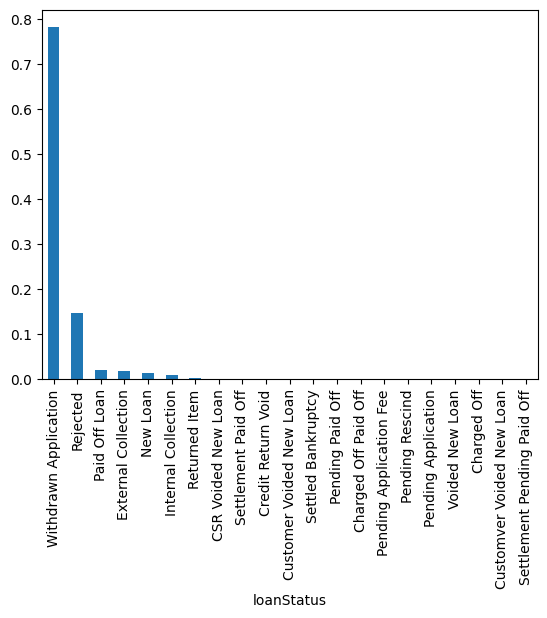

In [ ]:
loan_df['loanStatus'].value_counts(normalize=True).plot(kind='bar')

The distribution of loan statuses is depicted in a bar plot, with a strong bias towards the "Withdrawn Application" state, which makes up the vast bulk of the dataset. Few significant insights -

1. Data Bias and Skewedness:
Significantly Skew The "Withdrawn Application" status, which makes up about 78% of the dataset, is significantly favored in the data. Any predictive model may be seriously biased by the large number of withdrawn applications, especially if the goal is to predict loan risk or client behavior in relation to funded loans.
Effect on Accuracy of Model: If these withdrawn applications were included in the training set, the learning process of the model might be distorted, causing it to overfit to the withdrawn applications' attributes instead of correctly forecasting the risk.

2. Pertinence to Business Goals:
Application withdrawals are irrelevant from a business standpoint because they don't advance through the lending process, which means they don't produce income or pose a risk to repayment. There can be a wide range of reasons for withdrawal that have nothing to do with the features of the loan (e.g., better offers from competitors, changes in personal circumstances, or just a change of mind).
No Immediate Danger to Revenue: These clients do not add to the risk profile that the company must control because they did not finish the loan application procedure. Their presence in the model therefore undermines the primary goal of the company, which is to precisely predict and manage the risk related to funded loans.

3. Eliminating the withdrew applications from the dataset will improve the predictive model's relevance and accuracy. This would enable the model to learn the patterns and variables that lead to loan performance outcomes, such as default or successful repayment, by focusing on the subset of loans that were actually financed.
Prioritize Funded Loans: By optimizing lending methods, minimizing the risk associated with funded loans, and enhancing customer segmentation for future offers, this strategy will bring the model closer to the needs of the business.

In [ ]:
#Reducing the memory usage-
def reduce_mem_usage(df,name):
  """Reduces the memory usage of a dataset"""
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
  end_mem = df.memory_usage().sum() / 1024**2
  print(f"{name}")
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [ ]:
df_loan = reduce_mem_usage(loan_df,"Loan")
df_payment = reduce_mem_usage(payment_df, "Payment")
df_clarity = reduce_mem_usage(clarity_df, "Clarity")

Loan
Mem. usage decreased to 51.79 Mb (31.9% reduction)
Payment
Mem. usage decreased to 26.30 Mb (38.5% reduction)
Clarity
Mem. usage decreased to 16.80 Mb (18.1% reduction)


# **Data Exploration**

1. loan.csv - every row is a loan application or a successfully funded loan

2. payment.csv - every row represents an Automated Clearing House(ACH) transfers which are just electronic bank-to-bank money transfer

3. clarity_underwriting_variables.csv - containing underwriting information

In payments.csv file we can observe that there are multiple rows for each loanId indicating that each loan can have multiple payments. While joining this data with the loan data, we need to make sure that we capture all the rows since they represent different installments.


In [ ]:
df_ = pd.merge(df_loan, df_clarity, left_on="clarityFraudId", right_on="underwritingid", how="left")
df = pd.merge(df_, df_payment, left_on="loanId", right_on="loanId", how="left")
merged_df=pd.merge(df_loan,df_payment,left_on="loanId", right_on="loanId", how="left")

In [ ]:
df.to_csv('combined_df.csv')

1. We are using the combined data to get a sense of each variable present.  
2. We are going to perform initial exploration on this entire dataset to capture the initial basic information.

1. Due to the possibility of several payments associated with a single loan, loanId does have 47.1% distinct values.

2. payFrequency: Biweekly plans receive the highest number of payments, followed by weekly and monthly plans. These appear to be the most popular schedules among MoneyLion customers; this may be because biweekly and weekly payments provide higher interest rate options.

3. The name "apr" stands for "annual percentage rate," which I had assumed would refer to percentages rather than continuous values. After reviewing the ranges I discovered that they are actually credit scores, and the chart's value range appears to correspond with that of a credit score.

4. data reveals that 56.6% of loans pass the initial underwriting hurdle. Although I am aware that there are still steps in the process where a loan can be denied, I could mistakenly believe that these 56.6% of loans are all approved.

5. Compared to customers who have a history of not defaulting on their loans, 88.5% of customers on PaidOdd are first-time loan applicants, making them the hardest to predict whether or not they would be able to repay their debts.
compared to 56.6% that are authorized in the first stage, 56.2% of loans are actually granted.

6. According to isFunded, MoneyLion ultimately funds 54.8% of loans; the 1.4% discrepancy with the authorized status is the result of a customer canceling their loan after it has been successfully approved. To comprehend what is happening here, more information is required.

7. According to loanStatus, approximately 15.4% + 1.2% (Paid Off Loan and Settlement Paid Off) = 16.6% of borrowers have paid off their debt, making this task's favorable class. Since no loan was ever granted, 36.8% of the loans have a Withdrawn Application status, which prevents them from being classified as Not Paid Off. To properly distinguish between Paid Off Loan and Not Paid Off Loan, I will need further details on these 21 distinct values.

8. loanAmount displays the total amount of the loan, exclusive of interest, that the clients are requesting. Even after accounting for inflation, the typical loan amount (in USD or MYR) is 604, which is not a significant sum. The top three loan amounts are 400, 300, and 500.

9. state displays the US states that can be utilized to plot the loans on a map. It's possible that borrowers from particular states have higher loan default rates.

10. The current installment number, which ranges from 1 to 105, is displayed by installmentIndex. I'm not sure how to impute the 43.8% of missing data, which are numerical values and would suggest that no loan has been granted.
is 1.1% of customers, according to collection data, have trouble making their payments; these individuals are more likely to fail on a loan.
Customers would make payments in accordance with payFrequency; principle, fees, and paymentAmount are details regarding the payments made for an installment.

11. paymentStatus indicates that 22.0% of the payments are cancelled, but I'm not sure why this is the case—is it because MoneyLion canceled the payment or is it because the customer was unable to make the payment? It is necessary to consider segregating the statuses that signify the loan default and the statuses that demonstrate the loan repayment.



In [ ]:
#Segregating the columns in clarity data wrt specific identifier!
df_clarity.columns = df_clarity.columns.str.replace('.underwritingdataclarity.clearfraud.clear', '')
fraud_inquiry_columns = df_clarity.filter(regex='fraudinquiry').columns
fraud_indicator_columns = df_clarity.filter(regex='fraudindicator').columns
fraud_identity_verification_columns = df_clarity.filter(regex='fraudidentityverification').columns

In [ ]:
loan_df=loan_df[loan_df['loanStatus'] != 'Withdrawn Application']
loan_df.shape

(126698, 19)

In [ ]:
# Convert relevant columns to datetime
loan_df['applicationDate'] = pd.to_datetime(loan_df['applicationDate'], errors='coerce')
loan_df['originatedDate'] = pd.to_datetime(loan_df['originatedDate'], errors='coerce')
payment_df['paymentDate'] = pd.to_datetime(payment_df['paymentDate'], errors='coerce')

In [ ]:
# Create some derived features for analysis
loan_df['loanTenure'] = (loan_df['originatedDate'] - loan_df['applicationDate']).dt.days
loan_df['isReturningCustomer'] = loan_df['nPaidOff'] > 0
loan_df['hasMissedFirstPayment'] = loan_df['fpStatus'].apply(lambda x: x in ['Rejected', 'Skipped', 'Cancelled'])

In [ ]:
merged_df=pd.merge(loan_df, df_payment.loc[:, ["loanId", "isCollection","paymentStatus"]], left_on="loanId", right_on="loanId", how="left")
merged_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,loanTenure,isReturningCustomer,hasMissedFirstPayment,isCollection,paymentStatus
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6396.0,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0.0,False,False,False,Checked
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6396.0,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0.0,False,False,False,Checked
2,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6396.0,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0.0,False,False,False,Checked
3,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6396.0,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0.0,False,False,False,Checked
4,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6396.0,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0.0,False,False,False,Checked


In [ ]:
merged_df.shape

(776030, 24)

In [ ]:
df_aggregated = df_payment.groupby(["loanId"]).agg(
    total_amount_paid_payment=('paymentAmount', 'sum'),
    total_amount_paid_principal=('principal', 'sum'),
    total_amount_paid_fees=('fees', 'sum')
).reset_index()

In [ ]:
combined_df=pd.merge(merged_df, df_aggregated, left_on="loanId", right_on="loanId", how="left").drop_duplicates('loanId').reset_index()
combined_df.shape

(126443, 28)

<Axes: xlabel='isFunded'>

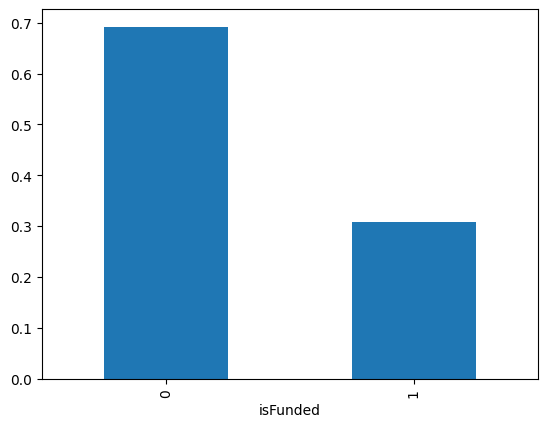

In [ ]:
combined_df['isFunded'].value_counts(normalize=True).plot(kind='bar')

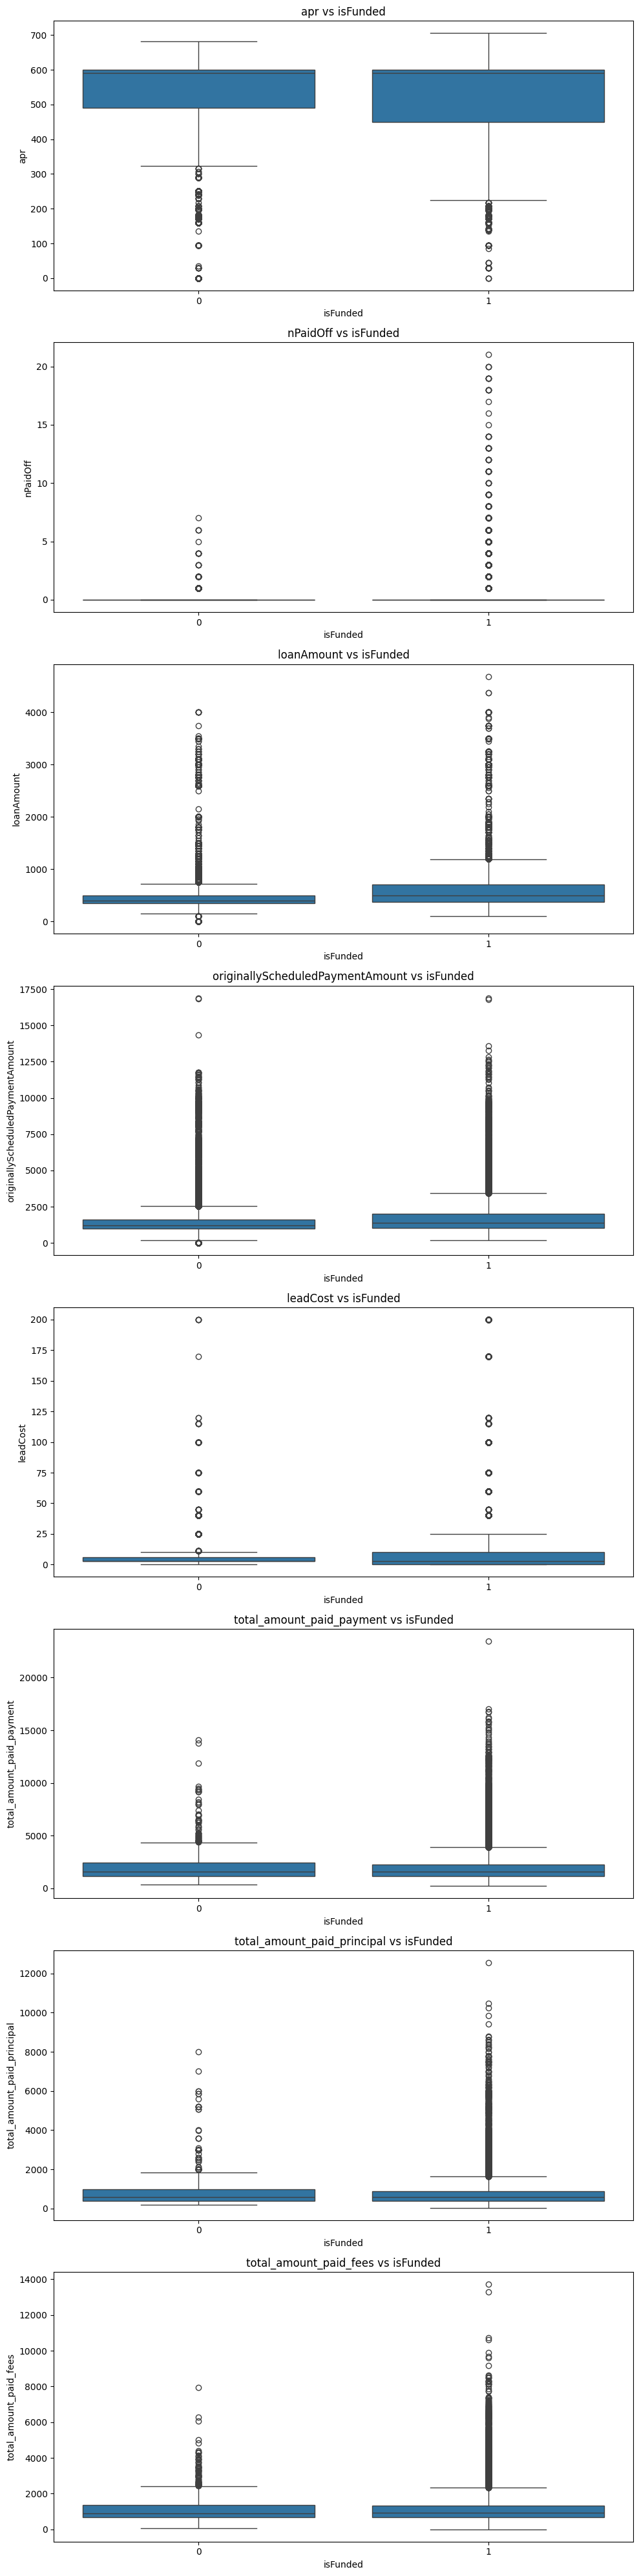

In [ ]:
def plot_columns_against_isFunded(df, columns, isFunded_column='isFunded'):
    num_columns = len(columns)
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, 5 * num_columns))

    for i, col in enumerate(columns):
        sns.boxplot(data=df, x=isFunded_column, y=col, ax=axes[i])
        axes[i].set_title(f'{col} vs {isFunded_column}')
        axes[i].set_xlabel(isFunded_column)
        axes[i].set_ylabel(col)

    plt.tight_layout()
    plt.show()
columns_to_plot = ['apr', 'nPaidOff','loanAmount','originallyScheduledPaymentAmount','leadCost',
                   'total_amount_paid_payment', 'total_amount_paid_principal', 'total_amount_paid_fees']

plot_columns_against_isFunded(combined_df, columns_to_plot)

The plots provided are box plots that compare various features (like APR, loan amount, lead cost, etc.) against the `isFunded` status, which indicates whether a loan was ultimately funded (1) or not (0). Here's a breakdown of the inferences you can draw from these plots:

### 1. **APR vs. isFunded:**
   - **Similarity in Distribution:** The APR (Annual Percentage Rate) distributions for both funded and unfunded loans are quite similar, with median APRs being close. This suggests that the APR alone may not be a strong distinguishing factor between loans that get funded and those that do not.
   - **Lower Outliers in Unfunded Loans:** There are more low-end outliers in the unfunded loans compared to the funded loans. This could indicate that some loans with particularly low APRs might not get funded, possibly due to being less profitable or attractive to lenders.

### 2. **nPaidOff vs. isFunded:**
   - **Higher Variability in Funded Loans:** The plot shows that for funded loans, the number of previously paid-off loans (nPaidOff) can reach higher values, though most data points are near zero. This suggests that customers who have paid off more loans in the past are slightly more likely to have their loans funded.
   - **Low nPaidOff for Unfunded Loans:** The distribution for unfunded loans is almost entirely at zero, indicating that customers with no history of paying off previous loans might be less likely to have their current loans funded.

### 3. **LoanAmount vs. isFunded:**
   - **Slightly Higher Loan Amounts in Funded Loans:** The distribution of loan amounts is slightly higher for funded loans compared to unfunded loans, although the difference is not very pronounced. Funded loans tend to include some higher amounts, which may suggest that lenders are more willing to fund larger loans, possibly due to higher expected returns.
   - **Similar Lower Ranges:** Both funded and unfunded loans have a similar range of smaller loan amounts, indicating that smaller loans are common regardless of whether they are funded or not.

### 4. **OriginallyScheduledPaymentAmount vs. isFunded:**
   - **Higher Scheduled Payments for Funded Loans:** Funded loans show slightly higher originally scheduled payment amounts compared to unfunded loans. This could suggest that loans with higher repayment expectations are more likely to be funded, possibly because they are perceived as more lucrative for the lender.
   - **Wide Range:** There is a wide range of scheduled payment amounts in both funded and unfunded loans, indicating variability in loan terms.

### 5. **LeadCost vs. isFunded:**
   - **Similar Distributions:** The lead cost, which could represent the cost of acquiring the lead, shows similar distributions for both funded and unfunded loans. This indicates that the cost of lead acquisition may not significantly influence whether a loan is funded.
   - **Presence of Outliers:** Both categories have outliers with high lead costs, though these are more prevalent in the funded loans, suggesting that higher lead costs might occasionally be justified by a successful funding outcome.

### 6. **Total Amount Paid (Payment, Principal, Fees) vs. isFunded:**
   - **Higher Total Amounts for Funded Loans:** Funded loans generally show higher total amounts paid, including total payments, principal, and fees, which is expected since these loans have been disbursed and have had time to accumulate payments.
   - **Larger Outliers in Funded Loans:** The funded loans have more significant outliers with higher total amounts paid, especially in principal and fees. This suggests that funded loans, particularly those with larger amounts, result in more substantial repayments and associated fees, which may be attractive to lenders.

### **Overall Inferences:**
   - **Influence of Loan and Payment Amounts:** Loan amount and originally scheduled payment amount appear to have some influence on whether a loan is funded, with slightly higher values tending to be associated with funded loans. This might reflect a lender preference for loans that promise higher returns.
   - **Limited Influence of APR and Lead Cost:** APR and lead cost distributions are quite similar between funded and unfunded loans, indicating that these factors alone may not strongly influence the funding decision.
   - **Importance of Borrower History:** The nPaidOff variable shows that having a history of repaying loans could slightly increase the likelihood of loan funding, suggesting that borrower reliability is a consideration in the funding decision.
   - **Focus on High-Value Loans:** Funded loans tend to include higher loan amounts, scheduled payments, and total repayments (principal and fees), indicating a preference for higher-value loans that could potentially offer greater returns.


Text(0, 0.5, 'Frequency')

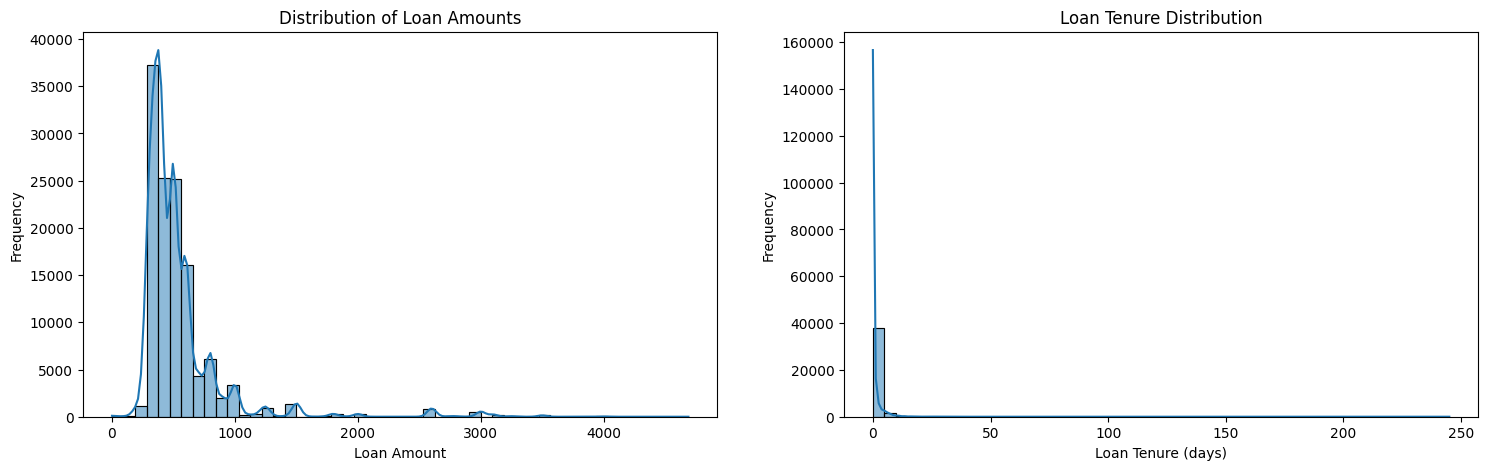

In [ ]:
plt.figure(figsize=(18, 5))

# 1. Distribution of Loan Amounts
plt.subplot(1, 2, 1)
sns.histplot(combined_df['loanAmount'], bins=50, kde=True)
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')

# 2. Loan Tenure Distribution
plt.subplot(1, 2, 2)
sns.histplot(combined_df['loanTenure'].dropna(), bins=50, kde=True)
plt.title('Loan Tenure Distribution')
plt.xlabel('Loan Tenure (days)')
plt.ylabel('Frequency')



Distribution of Loan amounts
1.  Right skewed distribution - majority of loan amounts clustered towards lower end of the scale. Most loans are relatively small with fewer instances
of larger loans.
2. Huge peak b/w 300 & 500 loan amounts, indicating this range is most common loan amongst the customers
3. Beyond 1000 loan frequency drops significantly, suggesting high value loans are rare. Maybe org. tends to issue smaller loans more frequently with
larger ones being less common.

Distribution of Loan Tenure
1. Short tenure dominance, most loans - short tenures (likely to be very short term loans)
2. Longer tenures - rare - Tenure inc ,freq drops (Beyond 50 days no of loans almost negligible)
3. The lack of longer-term loans could indicate a gap in the product offering. If there is a market demand for longer-term loans, expanding the product range could be an opportunity for business growth.
4. Customer Segmentation: The skewed distribution might also reflect a specific target demographic or customer base that prefers or requires short-term borrowing. Understanding this demographic could help tailor marketing and service offerings more effectively.

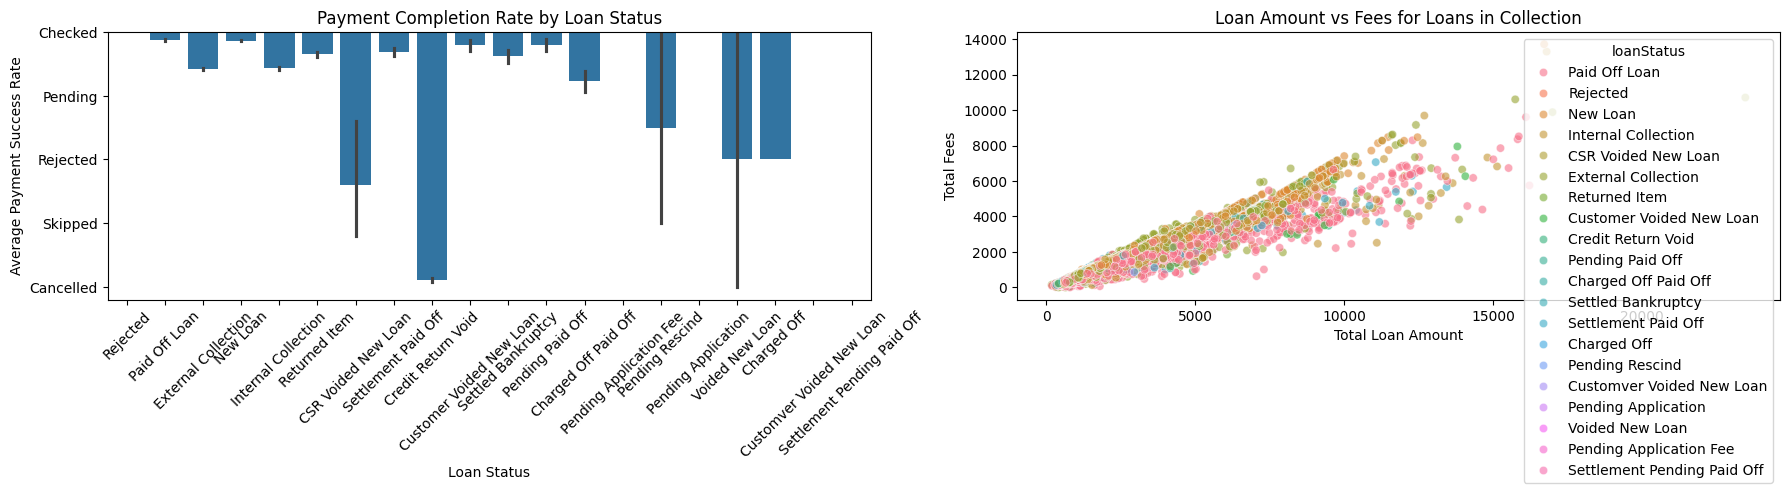

In [ ]:
plt.figure(figsize=(18, 5))

# 3. Payment Completion Rate by Loan Status
plt.subplot(1, 2, 1)
sns.barplot(data=combined_df, x='loanStatus', y='paymentStatus', order=combined_df['loanStatus'].value_counts().index)
plt.title('Payment Completion Rate by Loan Status')
plt.xticks(rotation=45)
plt.xlabel('Loan Status')
plt.ylabel('Average Payment Success Rate')

# 4. Payment Amount vs Fees for Loans in Collection
plt.subplot(1, 2, 2)
sns.scatterplot(data=combined_df, x='total_amount_paid_payment', y='total_amount_paid_fees', hue='loanStatus', alpha=0.6)
plt.title('Loan Amount vs Fees for Loans in Collection')
plt.xlabel('Total Loan Amount')
plt.ylabel('Total Fees')
#**** change required

plt.tight_layout()
plt.show()


### 1. **Payment Completion Rate by Loan Status:**
   - **Negative Payment Success Rates:**
     - **CSR Voided New Loan:** This loan status has the most negative impact on payment completion rates, indicating that loans classified under this status have a very low likelihood of successful payment. This might suggest significant issues or problems with these loans, such as fraud or early cancellations that lead to poor performance.
     - **Settled Bankruptcy and Charged Off Paid Off:** These statuses also show low payment completion rates, which is expected, as loans in bankruptcy or charged off generally reflect financial distress or inability to pay.
     - **Pending Paid Off:** The pending paid-off status also shows a low payment success rate, which might indicate delays or difficulties in finalizing payments, possibly due to administrative issues or borrower challenges.
   - **Better Payment Success Rates:**
     - **Paid Off Loan:** Loans classified as "Paid Off" show higher payment completion rates, as expected. This status reflects successful loan repayment, making it a positive indicator of borrower reliability.
     - **Settlement Paid Off:** This status, while showing some variability, generally indicates successful resolution through settlement, suggesting that borrowers who settle their loans are likely to make payments, albeit possibly after some difficulties.
   - **Canceled and Rejected Loans:** Loans that are canceled or rejected show low payment success rates, which is logical, as these loans are typically voided or terminated before significant payments are made.

### 2. **Loan Amount vs. Fees for Loans in Collection:**
   - **Positive Correlation:** The scatter plot shows a strong positive correlation between the total loan amount and the total fees for loans in collection. This correlation indicates that larger loan amounts tend to accrue higher fees when they enter the collection process. This is expected, as larger loans likely involve higher interest rates and fees, and these amounts can accumulate if the borrower defaults or enters collections.
   - **Loan Status Distribution:**
     - The data points are colored by loan status, and while the scatter of points seems fairly uniform across different statuses, certain loan statuses might have higher concentrations at specific ranges of loan amounts or fees. For example, statuses like "Internal Collection" and "External Collection" might cluster around higher loan amounts and fees, indicating more significant financial issues.
     - **Outliers:** There are some outliers with very high loan amounts and corresponding high fees. These outliers may represent particularly problematic loans that have escalated within the collection process, leading to significant financial penalties for the borrower.



These plots highlight the importance of monitoring loan status closely, as it directly impacts payment success rates and the potential accumulation of fees in collection. By focusing on high-risk loan categories and implementing proactive strategies, the business can improve overall loan performance and reduce the incidence of defaults and collections.

In [ ]:
# Create new features based on personal understanding
# 1. Payment Delinquency: Calculate the difference in days between scheduled payment dates
payment_df['next_payment_date'] = payment_df.groupby('loanId')['paymentDate'].shift(-1)
payment_df['days_between_payments'] = (payment_df['next_payment_date'] - payment_df['paymentDate']).dt.days

In [ ]:
# 2. Loan Approval Duration: Calculate the time taken from application to approval
combined_df['approvalDuration'] = (combined_df['originatedDate'] - combined_df['applicationDate']).dt.days

In [ ]:
# 3. Total Payment Amount as a percentage of Loan Amount
combined_df['payment_to_loan_ratio'] = combined_df['total_amount_paid_payment'] / combined_df['loanAmount']

In [ ]:
# Aggregations for more insights
# 1. Average loan amount by state
state_loan_agg = combined_df.groupby('state')['loanAmount'].mean().reset_index()

# 2. Average APR by lead type
leadtype_apr_agg = combined_df.groupby('leadType')['apr'].mean().reset_index()

# 3. Number of loans by lead type
leadtype_count_agg = combined_df['leadType'].value_counts().reset_index()
leadtype_count_agg.columns = ['leadType', 'count']

In [ ]:
leadtype_count_agg

,leadType,count
0,bvMandatory,101752
1,lead,12644
2,organic,8323
3,rc_returning,1850
4,prescreen,1772
5,california,50
6,lionpay,17
7,express,16
8,instant-offer,10
9,repeat,9


Text(0, 0.5, 'Frequency')

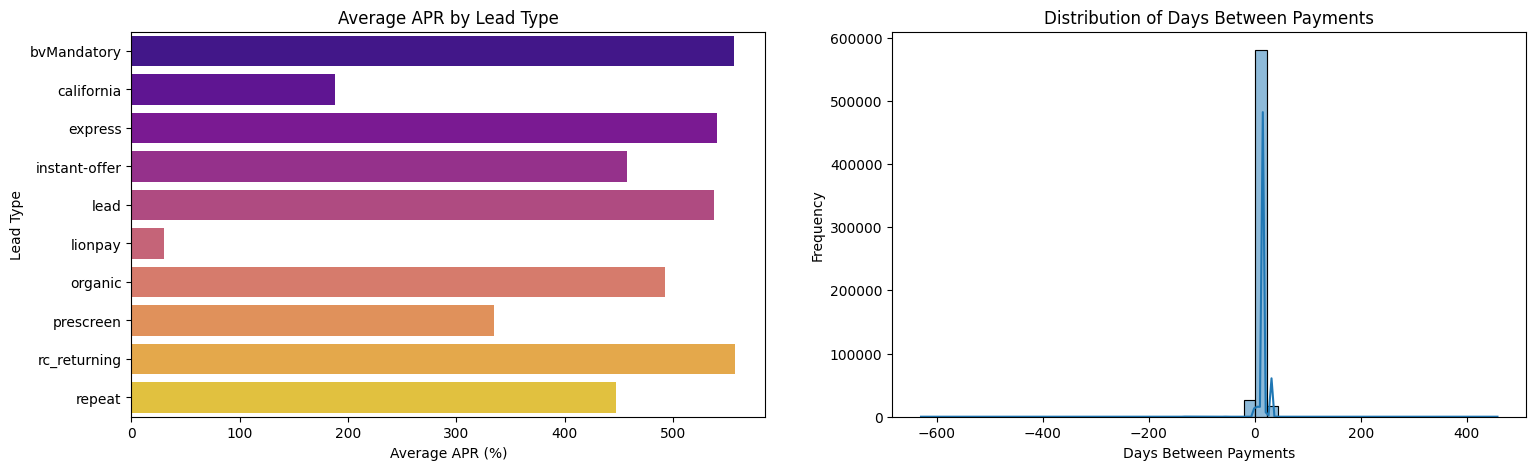

In [ ]:
plt.figure(figsize=(18, 5))


# 1. Average APR by Lead Type
plt.subplot(1, 2,1)
sns.barplot(data=leadtype_apr_agg, x='apr', y='leadType', palette='plasma')
plt.title('Average APR by Lead Type')
plt.xlabel('Average APR (%)')
plt.ylabel('Lead Type')


# 2. Days Between Payments (Payment Delinquency) Distribution
plt.subplot(1, 2, 2)
sns.histplot(payment_df['days_between_payments'].dropna(), bins=50, kde=True)
plt.title('Distribution of Days Between Payments')
plt.xlabel('Days Between Payments')
plt.ylabel('Frequency')

**Variation in APR Across Lead Types**

Highest APRs

*   bvMandatory: This lead type, which requires mandatory bank verification, has the highest average APR. This could indicate that the customers associated with this lead type are perceived as higher risk, hence the higher interest rate to compensate for the risk.
*   instant-offer and express: These promotional loan types also have high average APRs, suggesting that these are likely targeted towards higher-risk borrowers who are offered loans with attractive, quick approval processes but at higher interest rates.

*   Lead Types with Optional Verification (lead, organic): These lead types have relatively high APRs as well, possibly reflecting the additional risk taken by the lender when verification is optional or less stringent.





Lowest APRs

*   california: Loans under this lead type, optimized for California lending rules, have the lowest average APR. This could be due to state regulations that limit the maximum allowable APR, or it might reflect a customer base that is generally lower risk. The lower APR for the "california" lead type likely reflects the impact of state-specific lending regulations that protect consumers from excessively high interest rates. This underscores the importance of local regulations in shaping lending practices.
*  lionpay: This lead type also has a lower average APR, indicating that the underwriting rules or the customer profile associated with these leads are seen as lower risk.


 The variation in APRs across lead types indicates a clear use of risk-based pricing. Lead types that involve less stringent verification or are promotional in nature are priced higher, likely due to the increased risk of default or non-payment associated with these customers.






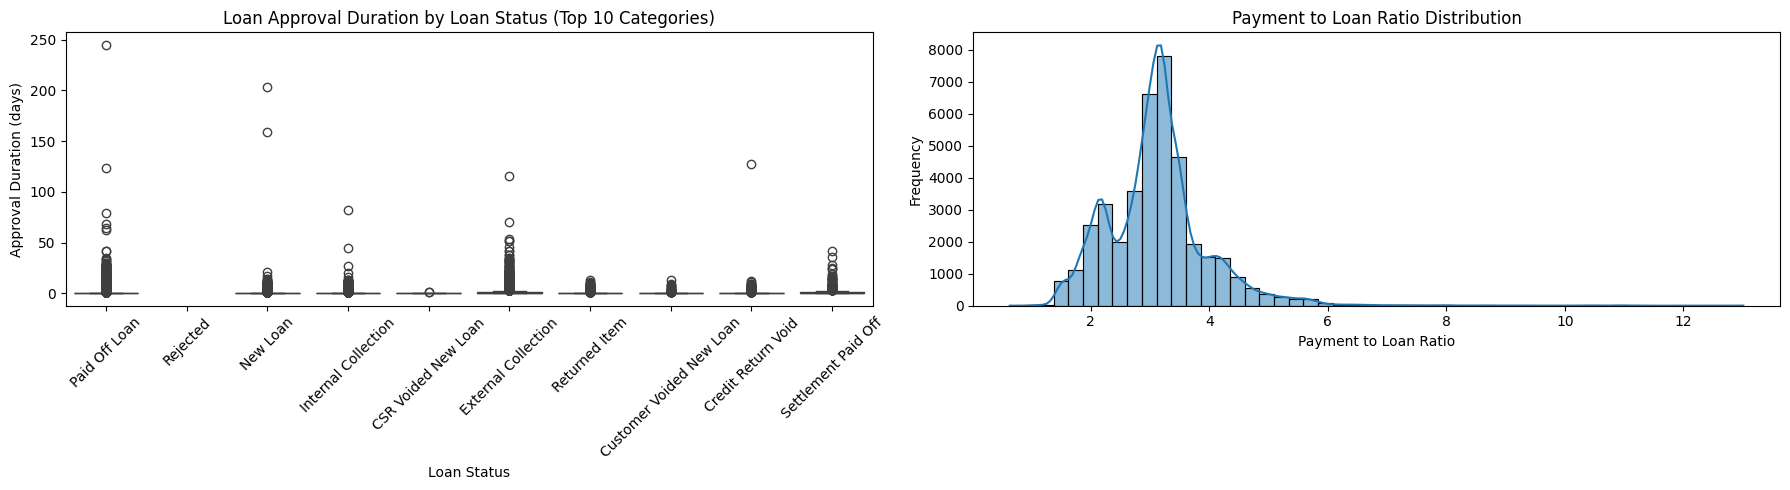

In [ ]:
# 5. Loan Approval Duration vs. Loan Status
plt.figure(figsize=(18, 5))
top_loan_status = combined_df['loanStatus'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 categories
filtered_loan_df = combined_df[combined_df['loanStatus'].isin(top_loan_status)]

# Create the boxplot
plt.subplot(1, 2,  1)
sns.boxplot(data=filtered_loan_df, x='loanStatus', y='approvalDuration')
plt.title('Loan Approval Duration by Loan Status (Top 10 Categories)')
plt.xlabel('Loan Status')
plt.ylabel('Approval Duration (days)')
plt.xticks(rotation=45)
# plt.show()

# 6. Payment to Loan Ratio Distribution
plt.subplot(1, 2, 2)
sns.histplot(combined_df['payment_to_loan_ratio'].dropna(), bins=50, kde=True)
plt.title('Payment to Loan Ratio Distribution')
plt.xlabel('Payment to Loan Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



### 1. **Loan Approval Duration by Loan Status:**
   - **General Observation:**
     - The plot shows the distribution of approval durations (in days) across various loan statuses. The majority of loans across different statuses have short approval durations, clustered close to zero days.
     - **Outliers:** There are several notable outliers where the approval duration extends significantly, even up to 250 days. These outliers appear across various loan statuses, suggesting that, in some cases, the approval process is considerably delayed.
  
   - **Specific Status Insights:**
     - **Paid Off Loan:** Most paid-off loans are approved quickly, with a few outliers showing extended approval times. This suggests that while most borrowers who eventually pay off their loans experience a smooth approval process, some require more time, possibly due to additional underwriting scrutiny.
     - **Rejected Loans:** Rejected loans show similar patterns with mostly short approval durations but also a few significant outliers. These outliers could indicate cases where the loan application was reconsidered multiple times before a final rejection.
     - **New Loan:** This status has a few outliers with extended approval durations, but the majority are processed quickly, indicating efficiency in handling new loan applications.
     - **Loans in Collection (Internal/External):** The presence of outliers in internal and external collections indicates that some loans, despite taking longer to approve, eventually face repayment issues, leading to collection actions.
     - **Voided and Rescinded Loans:** Some loans that are eventually voided or rescinded also show longer approval durations, possibly indicating complications or reconsiderations during the approval process.

### 2. **Payment to Loan Ratio Distribution:**
   - **Positive Skewness:**
     - The histogram shows that the payment to loan ratio is generally skewed to the right, with most loans having a ratio between 2 and 5. This means that, on average, borrowers are paying back between two and five times the original loan amount, likely due to interest, fees, and extended repayment periods.
  
   - **Mode and Central Tendency:**
     - The mode (most frequent value) appears around a ratio of 3. This suggests that the most common scenario for borrowers is to pay back about three times the amount they originally borrowed.
  
   - **Tail Analysis:**
     - The right tail of the distribution extends beyond a ratio of 6, indicating that some loans have much higher repayment amounts relative to the original loan amount. These could be cases where borrowers are heavily penalized or have high interest rates leading to significant fees.
  

In [ ]:
#Segregating the columns in clarity data wrt specific identifier!
df_clarity.columns = df_clarity.columns.str.replace('.underwritingdataclarity.clearfraud.clear', '')
fraud_inquiry_columns = df_clarity.filter(regex='fraudinquiry').columns
fraud_indicator_columns = df_clarity.filter(regex='fraudindicator').columns
fraud_identity_verification_columns = df_clarity.filter(regex='fraudidentityverification').columns

In [ ]:
fraud_indicators = df_clarity[fraud_indicator_columns].astype('float')

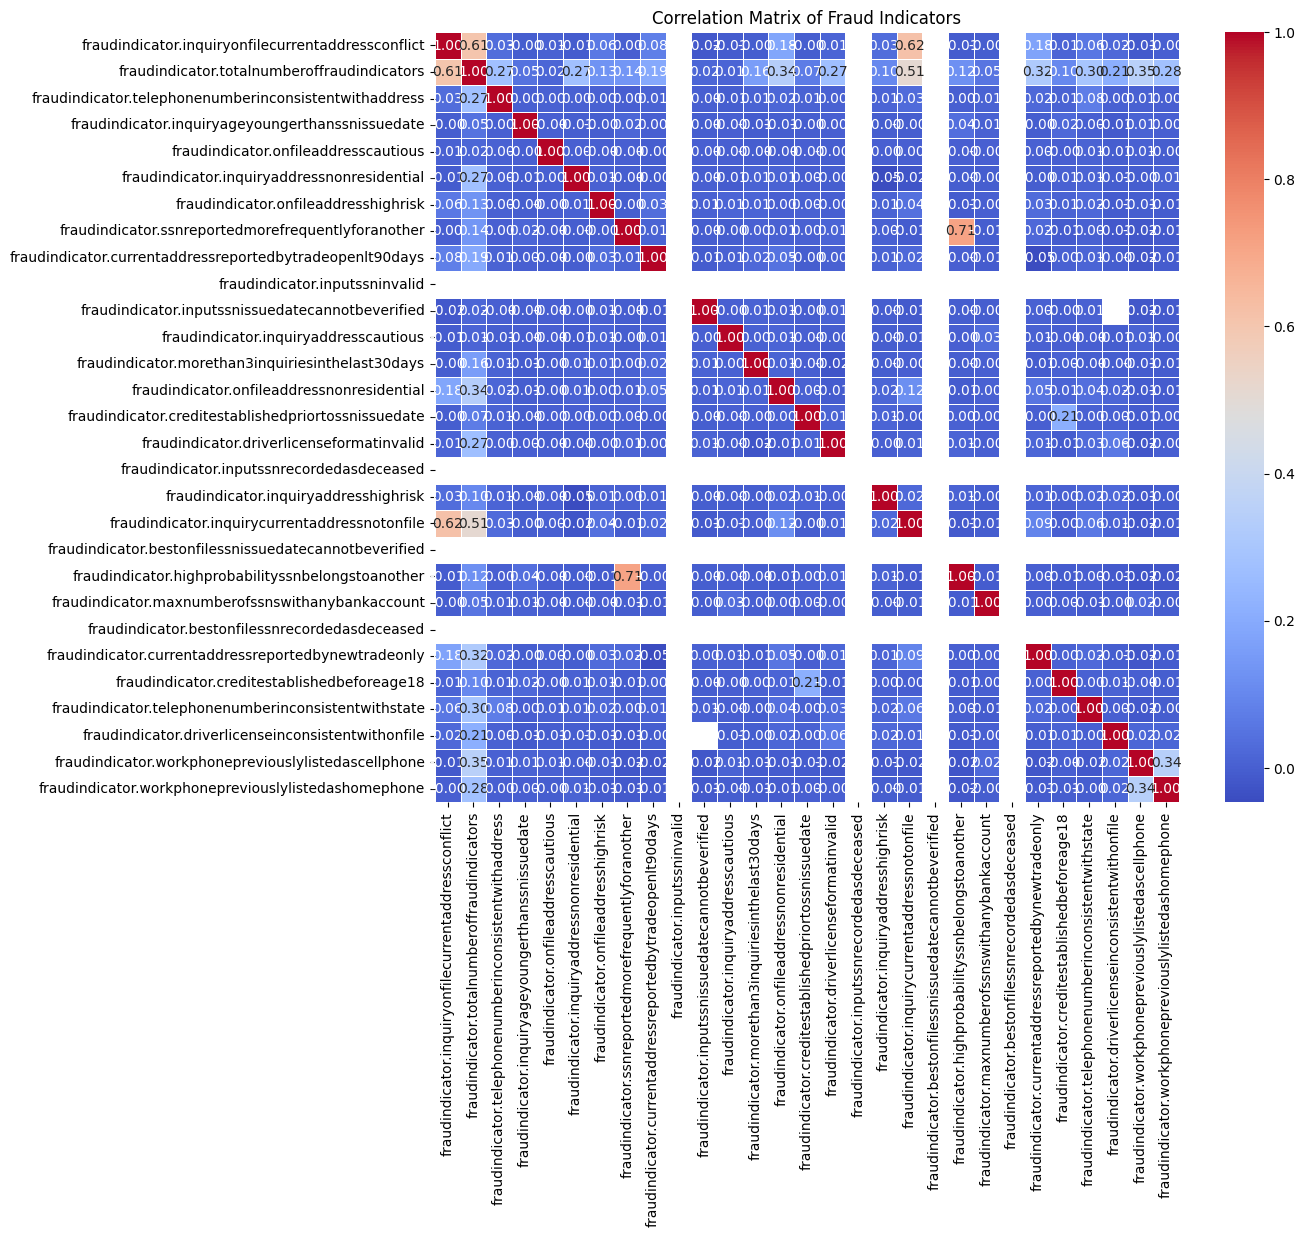

In [ ]:
correlation_matrix = fraud_indicators.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Fraud Indicators')
plt.show()

In [ ]:
combined_df['applicationMonth'] = combined_df['applicationDate'].dt.to_period('M')
combined_df['applicationQuarter'] = combined_df['applicationDate'].dt.to_period('Q')

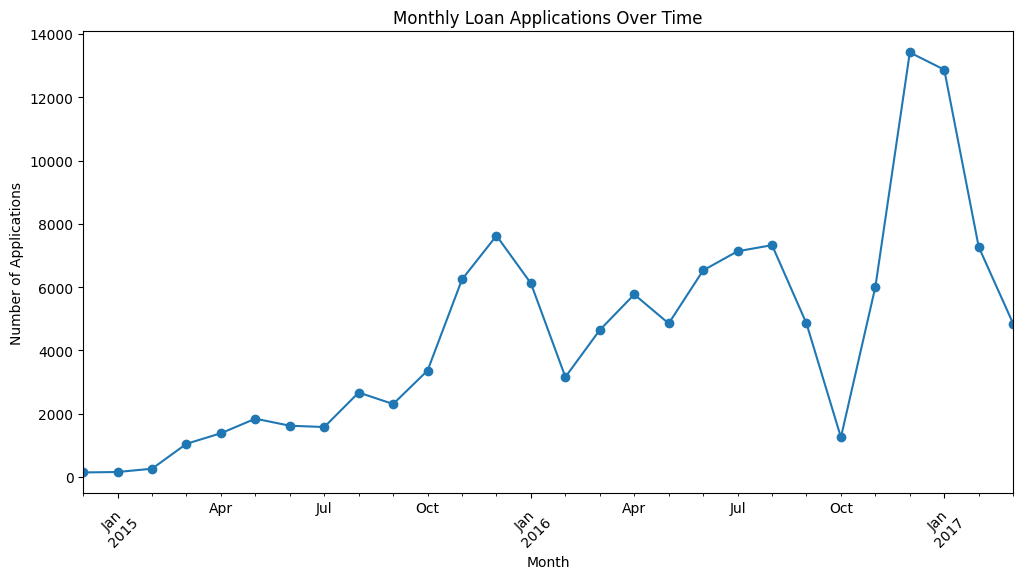

In [ ]:
# Group by month
monthly_applications = combined_df.groupby('applicationMonth').size()

# Group by quarter
quarterly_applications = combined_df.groupby('applicationQuarter').size()

# Plotting the monthly trend
plt.figure(figsize=(12, 6))
monthly_applications.plot(kind='line', marker='o')
plt.title('Monthly Loan Applications Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Applications')
plt.xticks(rotation=45)
plt.show()

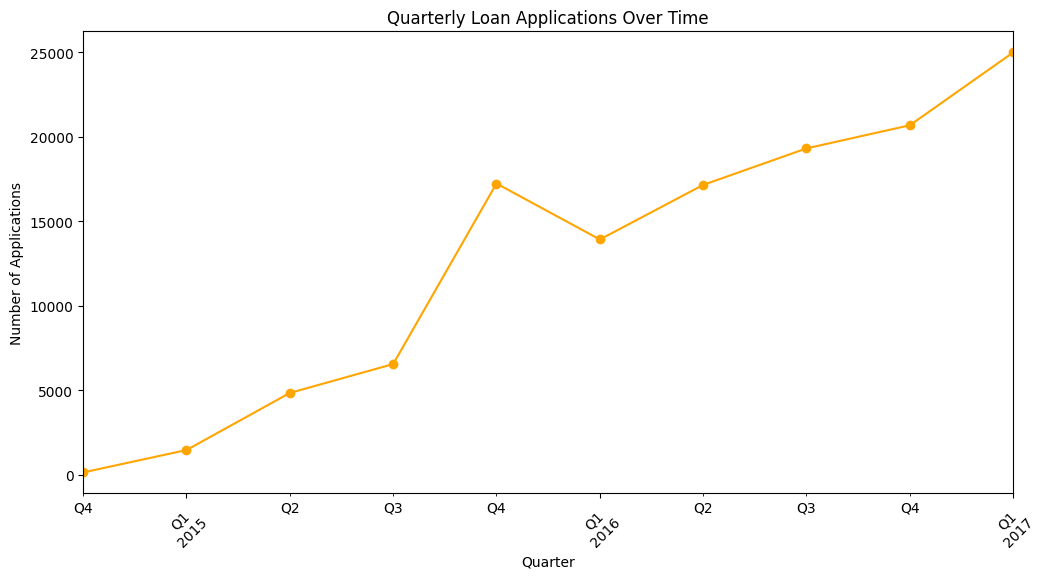

In [ ]:
# Plotting the quarterly trend
plt.figure(figsize=(12, 6))
quarterly_applications.plot(kind='line', marker='o', color='orange')
plt.title('Quarterly Loan Applications Over Time')
plt.xlabel('Quarter')
plt.ylabel('Number of Applications')
plt.xticks(rotation=45)
plt.show()




### 1. **Overall Growth in Loan Applications:**
   - **Upward Trend:** Both plots demonstrate a clear upward trend in the number of loan applications from January 2015 to the beginning of 2017. This indicates increasing demand for loans over time, which could be due to various factors such as economic conditions, marketing efforts, or the company’s growing reputation.
   - **Significant Growth Spikes:** There are several spikes in the number of applications, particularly noticeable in late 2016 and early 2017. These spikes suggest periods of heightened loan application activity, which could correspond with specific marketing campaigns, seasonal demand, or economic factors encouraging borrowing.

### 2. **Seasonal Patterns and Fluctuations:**
   - **Monthly Analysis:**
     - The number of applications tends to fluctuate throughout the year, with noticeable peaks in certain months (e.g., October 2016 and January 2017). This could suggest that certain times of the year see more loan applications, possibly due to seasonal factors like holiday spending, tax season, or year-end financial planning.
     - **Troughs:** There are also periods of low activity, such as in October 2015 and October 2016. Understanding the causes of these troughs could be important for planning and mitigating slow periods.

   - **Quarterly Analysis:**
     - The quarterly trend smooths out some of the monthly fluctuations, providing a clearer view of the overall growth. The sharp increase in Q4 2016 is particularly prominent, followed by a slight dip in Q1 2017, before continuing to rise.
     - **Sustained Growth:** Despite the slight dip in early 2017, the overall quarterly trend suggests sustained growth, indicating that the company’s loan products are increasingly in demand.

### 3. **Possible Influencing Factors:**
   - **Economic Conditions:** The steady increase in loan applications could be linked to broader economic conditions, where more individuals or businesses are seeking credit. For example, if interest rates were favorable during this period, it might have encouraged more borrowing.
   - **Marketing and Outreach:** Spikes in loan applications, particularly those sharp increases, could be attributed to successful marketing campaigns or promotions. Understanding what drove these spikes can help replicate such successes in the future.
   - **New Product Offerings:** If the company introduced new loan products or made improvements to the application process during this period, this could have contributed to the increased volume of applications.



The data shows a clear and consistent increase in loan application activity over the analyzed period, with certain months and quarters standing out due to significant spikes. These trends suggest a healthy and growing demand for the company’s loan products, which could be leveraged for strategic planning, marketing, and resource management. Understanding the underlying causes of both spikes and dips in applications will be crucial for maintaining and enhancing this growth trajectory.

In [ ]:
#Seasonal Trends Impacting Defaults ?

In [ ]:
# # Calculate default rate by month
# monthly_defaults = combined_df[combined_df['loanStatus'].isin(['Defaulted', 'Charged Off'])].groupby('applicationMonth').size()
# monthly_loans = combined_df.groupby('applicationMonth').size()
# monthly_default_rate = (monthly_defaults / monthly_loans).fillna(0)

# # Calculate default rate by quarter
# quarterly_defaults = combined_df[combined_df['loanStatus'].isin(['Defaulted', 'Charged Off'])].groupby('applicationQuarter').size()
# quarterly_loans = combined_df.groupby('applicationQuarter').size()
# quarterly_default_rate = (quarterly_defaults / quarterly_loans).fillna(0)

# # Plotting the monthly default rate
# monthly_default_rate.plot(kind='line', marker='o', figsize=(12, 6), title='Monthly Default Rate Over Time')
# plt.xlabel('Month')
# plt.ylabel('Default Rate')
# plt.show()

# # Plotting the quarterly default rate
# quarterly_default_rate.plot(kind='line', marker='o', figsize=(12, 6), color='orange', title='Quarterly Default Rate Over Time')
# plt.xlabel('Quarter')
# plt.ylabel('Default Rate')
# plt.show()



### 1. **Defaulted:**
   - **Reasoning:**
     - **Charged Off, External Collection, Internal Collection, Settled Bankruptcy, Settlement Pending Paid Off:**
       - These statuses indicate that the loan is in a state where the borrower has failed to meet their repayment obligations.
       - **Charged Off:** This status typically means that the lender has written off the loan as a loss after the borrower has defaulted on payments. The lender no longer expects to collect the full amount owed.
       - **External and Internal Collection:** These statuses indicate that the loan has been transferred to a collections department, either within the lender’s organization (internal) or to an external agency, signaling that the borrower is significantly behind on payments.
       - **Settled Bankruptcy:** This status implies that the borrower has filed for bankruptcy and the loan was settled as part of the bankruptcy process, often resulting in the lender recovering less than the full amount.
       - **Settlement Pending Paid Off:** This status suggests that the loan is in the process of being settled, which typically happens when the borrower cannot pay the full amount but negotiates a lower payoff amount, indicating financial distress.

   - **Assumption:**
     - Loans in these statuses have a high likelihood of financial loss for the lender, as the borrower has either defaulted or is in the process of defaulting on the loan. Classifying them under "Defaulted" helps in identifying loans that pose a significant risk and require specialized handling.

### 2. **Paid Off:**
   - **Reasoning:**
     - **Paid Off Loan, Settlement Paid Off, Charged Off Paid Off:**
       - These statuses indicate that the loan has been successfully repaid, either in full or through a settlement.
       - **Paid Off Loan:** This status is straightforward, indicating that the borrower has fulfilled their repayment obligations, and the loan is closed.
       - **Settlement Paid Off:** This status indicates that the loan was settled for less than the full amount but was nonetheless resolved to the lender’s satisfaction, typically after negotiations.
       - **Charged Off Paid Off:** Even though the loan was charged off initially, this status indicates that the borrower eventually made payments to settle the debt, though it was after the loan was written off.

   - **Assumption:**
     - Loans in these statuses are considered successfully resolved, either through full repayment or settlement. Classifying them under "Paid Off" highlights successful loan outcomes, which are important for assessing overall loan portfolio performance.

### 3. **Voided:**
   - **Reasoning:**
     - **CSR Voided New Loan, Customer Voided New Loan, Credit Return Void, Voided New Loan, Pending Rescind, Customver Voided New Loan:**
       - These statuses indicate that the loan was voided before it could fully materialize, either by the customer or due to issues detected by the lender.
       - **CSR Voided New Loan and Customer Voided New Loan:** These statuses reflect cases where either the lender’s customer service representative (CSR) or the borrower themselves canceled the loan, often before disbursement.
       - **Credit Return Void and Voided New Loan:** These are instances where the loan was voided due to credit-related issues or other reasons before it could be fully processed.
       - **Pending Rescind:** This status indicates that the loan is in the process of being rescinded, which means it is being canceled after initial approval but before disbursement.
       - **Customver Voided New Loan:** This appears to be a typo and likely should align with the other voided statuses, indicating borrower-initiated cancellation.

   - **Assumption:**
     - These loans never fully entered the repayment phase, often due to issues detected or decisions made early in the process. Classifying them under "Voided" helps distinguish loans that were canceled before they became active, thus not contributing to the portfolio’s performance.

### 4. **Rejected/Withdrawn:**
   - **Reasoning:**
     - **Withdrawn Application, Rejected, Pending Application, Pending Application Fee:**
       - These statuses indicate that the loan application was not successful in progressing to an active loan, either due to rejection by the lender or withdrawal by the borrower.
       - **Withdrawn Application:** Indicates that the borrower chose to withdraw their application, possibly due to finding better terms elsewhere or changes in financial needs.
       - **Rejected:** The lender did not approve the application, potentially due to credit issues or failure to meet underwriting criteria.
       - **Pending Application and Pending Application Fee:** These statuses suggest that the loan application was in process but never moved forward, either due to incomplete application steps or non-payment of required fees.

   - **Assumption:**
     - Loans in these statuses were never approved or funded, meaning they do not contribute to the loan portfolio in terms of risk or revenue. Classifying them under "Rejected/Withdrawn" helps in separating out applications that did not convert into actual loans.

### 5. **Active:**
   - **Reasoning:**
     - **New Loan, Returned Item:**
       - These statuses indicate that the loan is currently active and in the repayment phase.
       - **New Loan:** The loan has been approved, funded, and is now active, with the borrower expected to make payments according to the agreed-upon schedule.
       - **Returned Item:** This status typically indicates that a payment attempt was made but failed due to insufficient funds or other issues. However, the loan remains active and subject to future payment attempts.

   - **Assumption:**
     - Loans under these statuses are in the active repayment phase and should be monitored for ongoing performance. Classifying them under "Active" helps focus on loans that are currently generating revenue and may require collection efforts if payments are missed.

### 6. **Other:**
   - **Reasoning:**
     - This category captures any loan statuses that do not fit neatly into the above classifications.
     - **Assumption:**
       - By grouping less common or ambiguous statuses under "Other," the classification remains organized, while also acknowledging that not all loan statuses may fit into the primary categories. This category can be further analyzed to determine if additional sub-classifications are necessary.

### Conclusion:
The classification into these categories helps streamline the analysis and management of loans by grouping them into broader categories that reflect their current state and expected outcome. This approach enhances the ability to monitor, assess, and manage the loan portfolio effectively, focusing attention on areas of greatest financial impact, such as "Defaulted" loans for risk management and "Paid Off" loans for performance evaluation.

In [ ]:
def classify_loan_status(status):
    if status in ['Charged Off', 'External Collection', 'Internal Collection',
                  'Settled Bankruptcy', 'Settlement Pending Paid Off']:
        return 'Defaulted'
    elif status in ['Paid Off Loan', 'Settlement Paid Off','Charged Off Paid Off']:
        return 'Paid Off'
    elif status in ['CSR Voided New Loan', 'Customer Voided New Loan', 'Credit Return Void',
                    'Voided New Loan', 'Pending Rescind', 'Customver Voided New Loan']:
        return 'Voided'
    elif status in ['Withdrawn Application', 'Rejected', 'Pending Application', 'Pending Application Fee']:
        return 'Rejected/Withdrawn'
    elif status in ['New Loan', 'Returned Item']:
        return 'Active'
    else:
        return 'Other'

# Apply the function to create a new column
combined_df['loanStatusCategory'] = combined_df['loanStatus'].apply(classify_loan_status)


In [ ]:
state_defaults = combined_df[combined_df['loanStatusCategory'] == 'Defaulted'].groupby('state').size()
state_loans = combined_df.groupby('state').size()
state_default_rate = (state_defaults / state_loans).fillna(0).reset_index()
state_default_rate.columns = ['state', 'defaultRate']

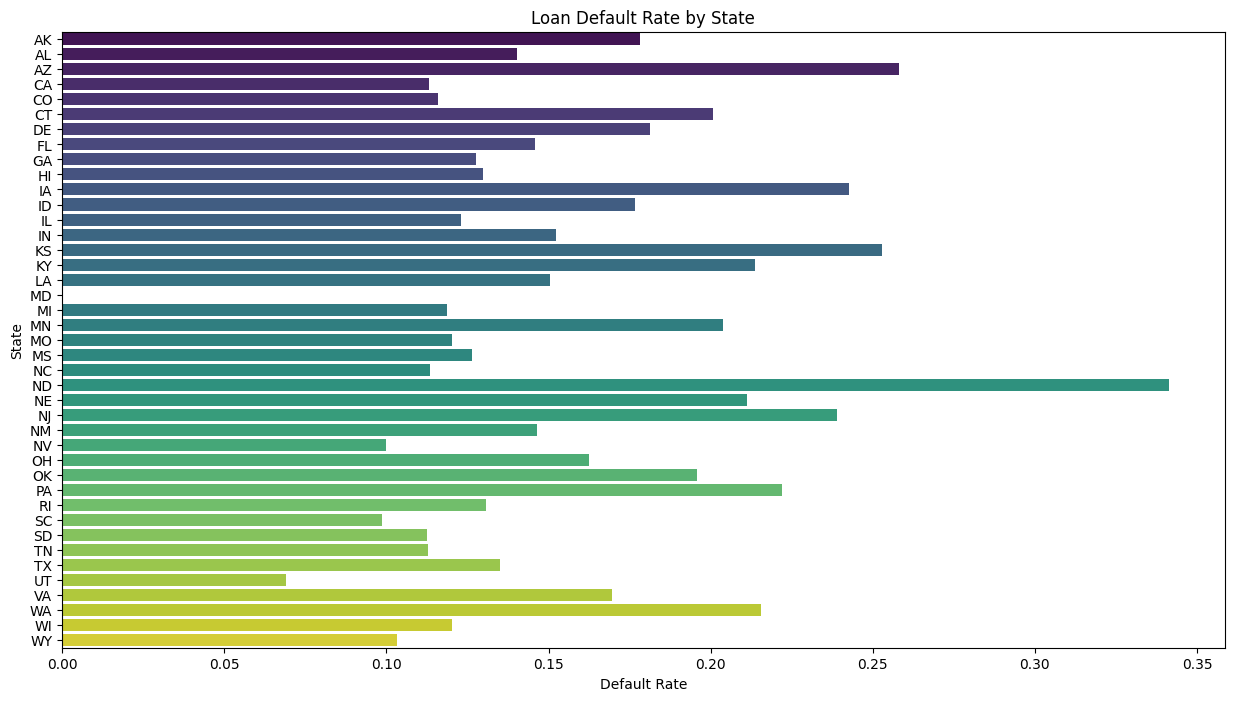

In [ ]:

plt.figure(figsize=(15, 8))
sns.barplot(data=state_default_rate, x='defaultRate', y='state', palette='viridis')
plt.title('Loan Default Rate by State')
plt.xlabel('Default Rate')
plt.ylabel('State')
plt.show()



### 1. **High Default Rates:**
   - **North Carolina (NC):** North Carolina stands out with the highest default rate, approaching 0.35 (or 35%). This is significantly higher than any other state and indicates a severe issue with loan defaults in this region.
   - **Nevada (NV):** Nevada also shows a relatively high default rate, around 0.25 (25%). This could reflect economic conditions or other factors specific to Nevada that make loan repayment more challenging for borrowers.
   - **Nebraska (NE):** Nebraska has a default rate slightly above 0.20 (20%), which is notable but not as extreme as North Carolina or Nevada.

### 2. **Moderate Default Rates:**
   - **States with Moderate Default Rates:** Several states, including South Dakota (SD), Missouri (MO), Texas (TX), and Wisconsin (WI), have default rates in the range of 0.15 to 0.20 (15% to 20%). These states might require closer monitoring and possibly targeted interventions to reduce default rates.

### 3. **Lower Default Rates:**
   - **States with Low Default Rates:** A large number of states, including states like California (CA), Florida (FL), New York (NY), and Michigan (MI), have relatively low default rates, generally below 0.10 (10%). This suggests better loan performance in these regions.
   - **States with Very Low Default Rates:** States like Alaska (AK), New Hampshire (NH), and Delaware (DE) have default rates near 0.05 (5%) or lower, indicating strong loan repayment behaviors in these areas.

### 4. **Geographic Trends and Implications:**
   - **Economic and Demographic Factors:** The variations in default rates across states likely reflect underlying economic conditions, employment rates, and demographic factors that influence borrowers' ability to repay loans. For example, higher default rates in North Carolina and Nevada might be linked to local economic challenges, such as unemployment rates or housing market conditions.
   - **Risk Management:** For states with high default rates like North Carolina, Nevada, and Nebraska, lenders might need to implement stricter credit criteria, offer more financial education, or provide alternative loan products that are better suited to the economic realities of these areas.
   - **Marketing and Product Strategies:** States with lower default rates could be targeted for marketing efforts, as they represent regions with more reliable borrowers. Additionally, understanding why these states perform better could provide insights into best practices that can be applied elsewhere.



This chart highlights significant geographic disparities in loan default rates across the United States. The notably high default rates in North Carolina, Nevada, and Nebraska suggest these states may benefit from targeted risk mitigation strategies. Conversely, states with lower default rates could be leveraged for growth opportunities, given their stronger loan performance. Understanding and addressing the causes behind these patterns is crucial for optimizing loan portfolios and minimizing financial risks.

In [ ]:
df.columns=df.columns.str.replace('.underwritingdataclarity.clearfraud.clear', '')

In [ ]:
df = pd.merge(combined_df, df_clarity, left_on="clarityFraudId", right_on="underwritingid", how="left")
df.shape

(126443, 87)

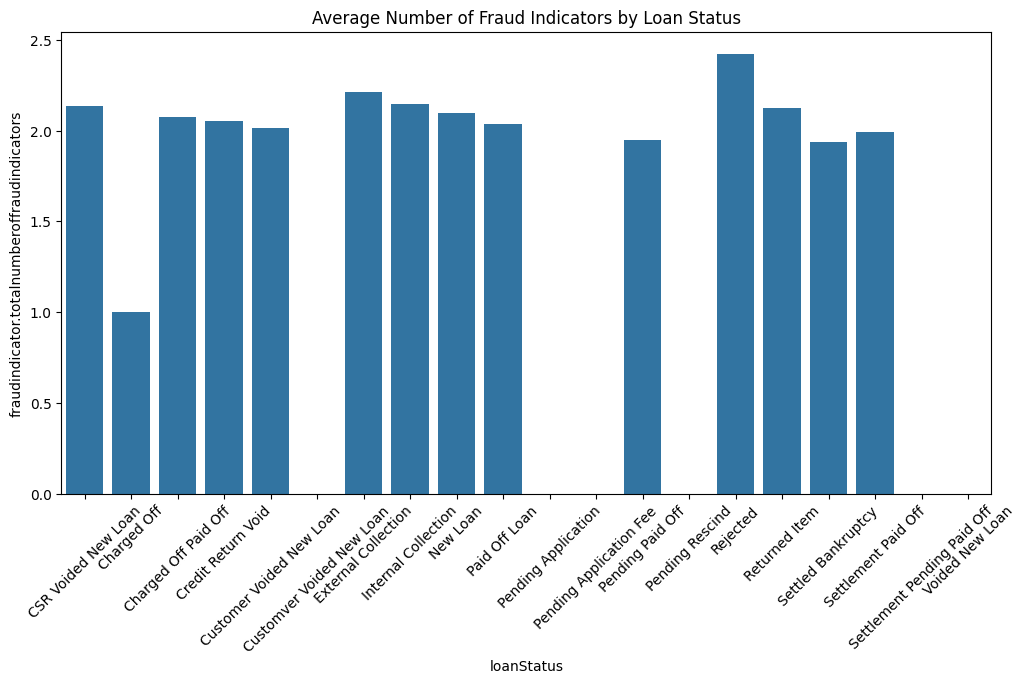

In [ ]:
# Group by loan status and calculate the mean of fraud indicators
fraud_by_status = df.groupby('loanStatus')[['fraudindicator.totalnumberoffraudindicators']].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_status, x='loanStatus', y='fraudindicator.totalnumberoffraudindicators')
plt.title('Average Number of Fraud Indicators by Loan Status')
plt.xticks(rotation=45)
plt.show()

This bar chart shows the average number of fraud indicators associated with different loan statuses:

### 1. **High Fraud Indicators:**
   - **Settled Bankruptcy:** This status shows the highest average number of fraud indicators, close to 2.5. This suggests that loans associated with bankruptcy are more likely to have multiple red flags for fraud, which could indicate that borrowers facing financial distress may be more prone to fraudulent activities or that fraud detection is heightened in such cases.
   - **External Collection and Internal Collection:** These loan statuses also exhibit a high average number of fraud indicators, around 2.0 to 2.2. Loans that go into collection often have higher risks, and this data suggests that they are also more likely to have been flagged for potential fraud.

### 2. **Moderate Fraud Indicators:**
   - **Voided New Loan (CSR Voided, Customer Voided, Voided New Loan):** These statuses show an average number of fraud indicators around 2.0. Loans that are voided, whether by customer or the lender's customer service representative, often involve situations where potential fraud was detected, leading to the loan being canceled before it could be disbursed.
   - **Rejected Loans:** Loans that were rejected also show a moderate number of fraud indicators, suggesting that part of the reason for rejection could be due to potential fraud concerns flagged during the underwriting process.

### 3. **Lower Fraud Indicators:**
   - **Charged Off and Charged Off Paid Off:** These statuses have a lower average number of fraud indicators, particularly the "Charged Off Paid Off" status, which suggests that while these loans may have ended up in default or charged off, they were not initially flagged with many fraud concerns.
   - **Paid Off Loan:** The average number of fraud indicators is lower for loans that were successfully paid off, which is expected as these loans likely involved less risky and more trustworthy borrowers.
   - **Pending Application/Pending Application Fee:** These statuses also have a moderate to low number of fraud indicators, which may reflect that the loan applications did not progress far enough to trigger many fraud checks or that they were halted early due to initial concerns.

### 4. **Implications for Risk Management:**
   - **Fraud Prevention Focus:** The data suggests that particular attention should be paid to loan statuses with high fraud indicators, such as those related to bankruptcy, collections, and voided loans. These categories might benefit from enhanced fraud prevention measures, more rigorous verification processes, or additional scrutiny during underwriting.
   - **Successful Loans:** The lower fraud indicators in paid-off loans reaffirm the importance of fraud detection in maintaining a healthy loan portfolio. Ensuring that loans with lower fraud risks are more likely to be approved and funded can contribute to better overall portfolio performance.



 Loans associated with bankruptcy, collections, and voided statuses are more likely to have multiple fraud indicators, suggesting that these areas require focused fraud prevention efforts. Conversely, loans that were successfully paid off or charged off (but later paid off) tend to have fewer fraud indicators, indicating lower risk in these cases. Understanding these patterns can help improve risk management and loan approval processes.

In [ ]:
def plot_distribution_vs_loan_outcomes(data, column_name):
    # Distribution of the column
    distribution = data[column_name].value_counts().reset_index()
    distribution.columns = [column_name, 'count']

    # Calculate the percentage of Paid Off loans by the column
    paid_off_percentage = data[data['loanStatusCategory'] == 'Paid Off'].groupby(column_name).size() / data.groupby(column_name).size() * 100
    paid_off_percentage = paid_off_percentage.reset_index()
    paid_off_percentage.columns = [column_name, 'paidOffPercentage']

    # Calculate the percentage of Defaulted loans by the column
    defaulted_percentage = data[data['loanStatusCategory'] == 'Defaulted'].groupby(column_name).size() / data.groupby(column_name).size() * 100
    defaulted_percentage = defaulted_percentage.reset_index()
    defaulted_percentage.columns = [column_name, 'defaultedPercentage']

    # Merge the dataframes for combined plotting
    combined_data = pd.merge(distribution, paid_off_percentage, on=column_name)
    combined_data = pd.merge(combined_data, defaulted_percentage, on=column_name)

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for the column distribution
    sns.barplot(data=combined_data, x=column_name, y='count', ax=ax1, palette='Blues_d')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{column_name} Distribution and % of Loan Outcomes')

    # Create a secondary y-axis for the line plot
    ax2 = ax1.twinx()
    sns.lineplot(data=combined_data, x=column_name, y='paidOffPercentage', ax=ax2, marker='o', color='green', label='% of Paid Off Loans')
    sns.lineplot(data=combined_data, x=column_name, y='defaultedPercentage', ax=ax2, marker='o', color='red', label='% of Defaulted Loans')
    ax2.set_ylabel('Percentage')

    # Add percentage labels to the line plots
    for x, y in zip(combined_data[column_name], combined_data['paidOffPercentage']):
        ax2.text(x=x, y=y+0.5, s=f'{y:.1f}%', ha='center', color='green')

    for x, y in zip(combined_data[column_name], combined_data['defaultedPercentage']):
        ax2.text(x=x, y=y+0.5, s=f'{y:.1f}%', ha='center', color='red')

    plt.show()

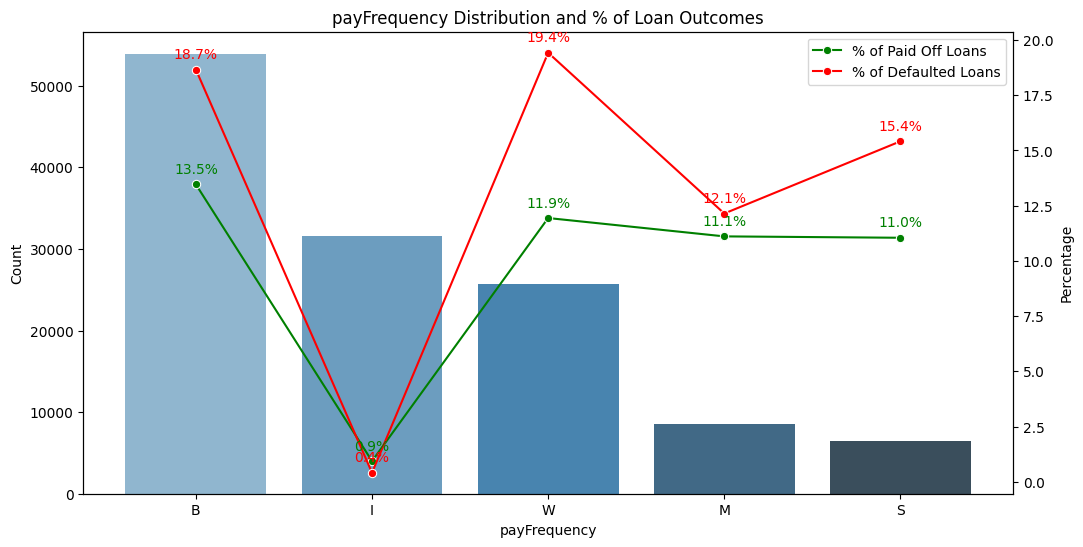

In [ ]:
plot_distribution_vs_loan_outcomes(df,'payFrequency')

This plot provides insights into the distribution of loan outcomes based on the payment frequency (`payFrequency`). The plot shows the count of loans for each payment frequency, along with the percentage of loans that were paid off or defaulted for each category.

### 1. **Biweekly Payments (B):**
   - **High Count, Moderate Performance:**
     - **Count:** Biweekly payment frequency has the highest number of loans, with over 50,000 loans.
     - **Default Rate:** The default rate for this category is 18.7%, which is relatively high compared to other payment frequencies.
     - **Paid Off Rate:** The percentage of loans that were paid off is 13.5%, which is moderate but lower than the default rate.

   - **Inference:** While biweekly payments are the most common, they also have a relatively high default rate. This suggests that borrowers with biweekly payments may be struggling more with repayments, potentially due to the frequency of payment or the nature of the borrowers who select this option.

### 2. **Irregular Payments (I):**
   - **Moderate Count, High Default Risk:**
     - **Count:** Irregular payment frequency has a significant number of loans, but less than biweekly payments.
     - **Default Rate:** This category has the highest default rate at 19.4%, which is concerning.
     - **Paid Off Rate:** Interestingly, the paid off rate is extremely low at only 0.4%, indicating that very few loans with irregular payments are successfully repaid.

   - **Inference:** Loans with irregular payment frequencies are highly risky, as evidenced by the highest default rate and the lowest paid off rate. This category likely includes borrowers who are less financially stable or have more unpredictable incomes, making regular payments challenging.

### 3. **Weekly Payments (W):**
   - **Moderate Count, Balanced Performance:**
     - **Count:** Weekly payment frequency has a lower loan count compared to biweekly and irregular payments.
     - **Default Rate:** The default rate is 12.1%, which is lower than the biweekly and irregular categories.
     - **Paid Off Rate:** The paid off rate is 11.9%, which is closer to the default rate, indicating a more balanced loan performance.

   - **Inference:** Weekly payments appear to be a more manageable frequency for borrowers, resulting in a better balance between default and paid off rates. This might indicate that borrowers who choose weekly payments are better able to manage their cash flow.

### 4. **Monthly Payments (M):**
   - **Lower Count, Stable Performance:**
     - **Count:** Monthly payment frequency has fewer loans than the previous categories.
     - **Default Rate:** The default rate is 12.1%, similar to weekly payments.
     - **Paid Off Rate:** The paid off rate is 11.1%, slightly lower than weekly payments, but still indicating stability.

   - **Inference:** Monthly payments, like weekly payments, show a stable loan performance. This frequency is likely attractive to borrowers who receive monthly incomes, and the relatively balanced default and paid off rates reflect this stability.

### 5. **Semi-Monthly Payments (S):**
   - **Lowest Count, Moderate Risk:**
     - **Count:** Semi-monthly payment frequency has the lowest loan count among all categories.
     - **Default Rate:** The default rate is 15.4%, which is higher than weekly and monthly payments but lower than biweekly and irregular payments.
     - **Paid Off Rate:** The paid off rate is 11.0%, indicating that while there are fewer loans, they still have a moderate risk of default.

   - **Inference:** Semi-monthly payments might be challenging for some borrowers, leading to a higher default rate compared to weekly and monthly payments. The lower loan count suggests that fewer borrowers opt for this payment frequency, possibly due to personal financial planning preferences.

### **Overall Inferences:**
- **Risk Management:** Irregular and biweekly payment frequencies are associated with higher default rates, suggesting that these categories should be closely monitored for risk. These borrowers might benefit from additional support or intervention to prevent defaults.
- **Stable Payment Frequencies:** Weekly and monthly payment frequencies show more balanced loan outcomes, indicating that these options might be more suitable for borrowers who require a stable repayment plan aligned with their income schedules.
- **Product Strategy:** The data suggests that offering more flexible repayment options might help mitigate defaults, particularly for borrowers with irregular income streams. Additionally, understanding the borrower profiles associated with each payment frequency can help tailor loan products to better meet their needs.


The analysis reveals that payment frequency plays a significant role in loan performance, with certain frequencies like irregular and biweekly being more prone to defaults. Understanding these patterns can inform strategies to improve loan repayment outcomes and reduce risk across the loan portfolio.

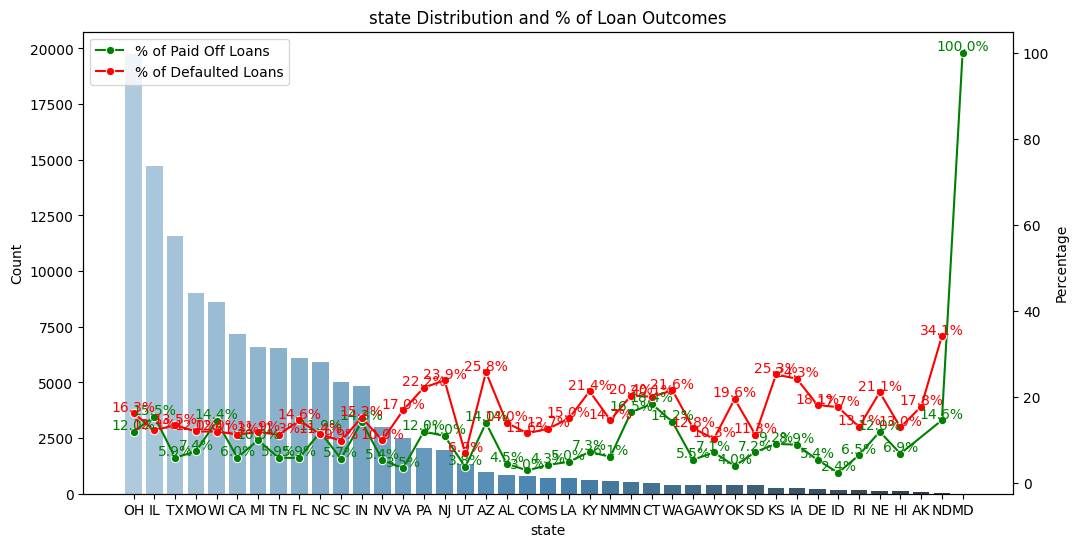

In [ ]:
plot_distribution_vs_loan_outcomes(df,'state')

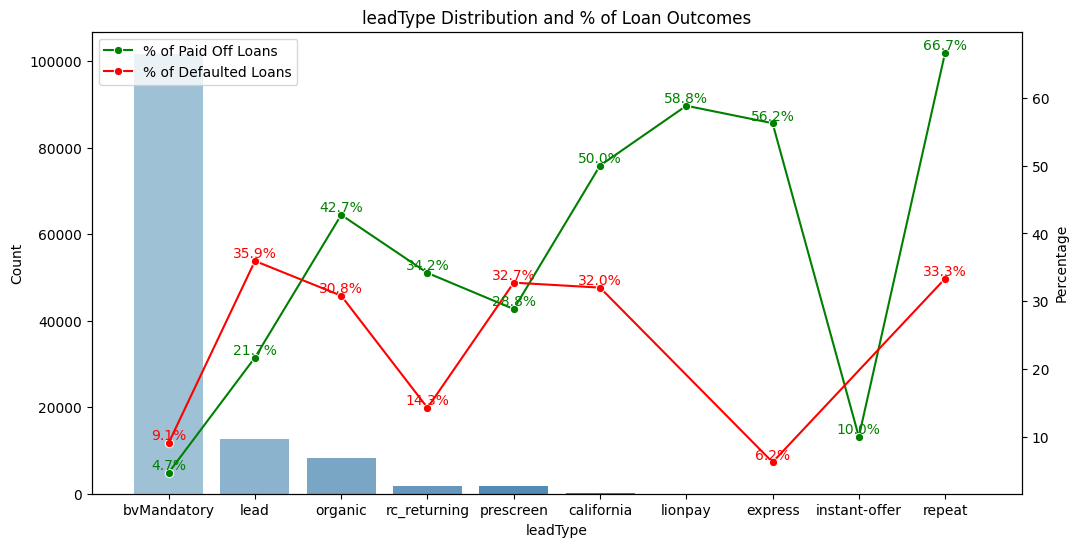

In [ ]:
plot_distribution_vs_loan_outcomes(df,'leadType')

This plot provides insights into the distribution of loan outcomes based on the `leadType`, which determines the underwriting rules for a loan. The chart shows the count of loans for each lead type, along with the percentage of loans that were paid off or defaulted

### 1. **bvMandatory:**
   - **High Volume, High Default Risk:**
     - **Count:** bvMandatory has the highest count of loans, with over 100,000 loans.
     - **Default Rate:** The default rate is 9.1%, which, while not the highest, is significant due to the large volume of loans in this category.
     - **Paid Off Rate:** The paid off rate is relatively low at 4.7%, indicating that a smaller proportion of these loans are successfully repaid.

   - **Inference:** Loans under bvMandatory are subject to mandatory bank verification, yet they still exhibit a relatively high default rate. This suggests that while the verification process filters out some risk, a large volume of these loans still struggle with repayment.

### 2. **Lead:**
   - **Moderate Volume, High Default Rate:**
     - **Count:** Lead has a moderate count of loans.
     - **Default Rate:** The default rate is notably high at 35.9%, which is concerning.
     - **Paid Off Rate:** The paid off rate is 21.7%, higher than bvMandatory, but still significantly lower than the default rate.

   - **Inference:** Similar to bvMandatory but without mandatory bank verification, loans in this category are at a higher risk of default. The lack of mandatory verification might contribute to the increased default rate.

### 3. **Organic:**
   - **Moderate Volume, Balanced Outcomes:**
     - **Count:** Organic leads have a moderate loan count.
     - **Default Rate:** The default rate is 30.8%, relatively high but slightly lower than Lead.
     - **Paid Off Rate:** The paid off rate is 42.7%, which is one of the highest among the lead types.

   - **Inference:** Customers coming through the MoneyLion website (Organic) show a higher likelihood of repaying their loans compared to Lead, possibly indicating that self-initiated applicants (versus those coming through lead generation) are more financially stable or better informed about their financial commitments.

### 4. **rc_returning:**
   - **Low Volume, High Success Rate:**
     - **Count:** This lead type has a low count of loans.
     - **Default Rate:** The default rate is relatively low at 14.3%.
     - **Paid Off Rate:** The paid off rate is 34.2%, indicating a good success rate.

   - **Inference:** Returning customers with at least one paid off loan in another portfolio have a higher likelihood of successfully repaying their loans. This suggests that prior positive borrowing history is a strong indicator of future repayment behavior.

### 5. **California:**
   - **Low Volume, Balanced Outcomes:**
     - **Count:** California lead type has a low loan count.
     - **Default Rate:** The default rate is 23.8%, moderate compared to other lead types.
     - **Paid Off Rate:** The paid off rate is 32.7%, showing a balanced outcome.

   - **Inference:** Loans optimized for California lending rules show a balanced risk profile, with a reasonable proportion of loans being repaid successfully.

### 6. **Lionpay:**
   - **Low Volume, High Success Rate:**
     - **Count:** Lionpay has a low count of loans.
     - **Default Rate:** The default rate is 32.0%, relatively high.
     - **Paid Off Rate:** The paid off rate is 58.8%, one of the highest, indicating strong repayment success.

   - **Inference:** Despite the high default rate, the high paid off rate suggests that borrowers under Lionpay, who likely have more structured repayment plans, are generally successful in repaying their loans.

### 7. **Express:**
   - **Very Low Volume, High Success Rate:**
     - **Count:** Express loans have a very low count.
     - **Default Rate:** The default rate is extremely low at 6.2%.
     - **Paid Off Rate:** The paid off rate is 56.2%, indicating a high success rate.

   - **Inference:** Promotional "express" loans are highly successful, with a low risk of default. This suggests that these loans are either well-targeted or involve more creditworthy borrowers.

### 8. **Instant-offer:**
   - **Low Volume, Low Success Rate:**
     - **Count:** Instant-offer loans have a low loan count.
     - **Default Rate:** The default rate is 10.0%, moderate compared to other lead types.
     - **Paid Off Rate:** The paid off rate is very low at 10.0%.

   - **Inference:** Instant-offer loans, despite being promotional, have a relatively high risk of default and a low success rate. This might indicate that these offers attract higher-risk borrowers who struggle with repayment.

### 9. **Repeat:**
   - **Low Volume, Highest Success Rate:**
     - **Count:** Repeat loans have a low count.
     - **Default Rate:** The default rate is moderate at 33.3%.
     - **Paid Off Rate:** The paid off rate is the highest at 66.7%, suggesting a strong likelihood of repayment.

   - **Inference:** Promotional loans offered through SMS to returning customers show the highest likelihood of being paid off. This indicates that targeting repeat customers, especially those with a history of successful repayments, is an effective strategy.

### **Overall Inferences:**
- **High-Risk Categories:** Lead and Organic categories, despite having moderate paid off rates, exhibit high default rates, indicating that these segments may require stricter underwriting criteria or additional borrower support.
- **Successful Segments:** Rc_returning, Lionpay, Express, and Repeat categories show strong repayment success, suggesting these segments are lower risk and might be prioritized in future lending strategies.
- **Targeting and Strategy:** The differences in default and paid off rates across lead types highlight the importance of tailoring loan products and underwriting rules to specific borrower profiles. Promoting products like Express and Repeat loans to targeted, low-risk customers can enhance overall portfolio performance.


This analysis underscores the importance of understanding the nuances of different lead types in loan performance. By leveraging these insights, lenders can optimize their strategies to minimize defaults and maximize successful loan repayments, ultimately improving profitability and risk management.

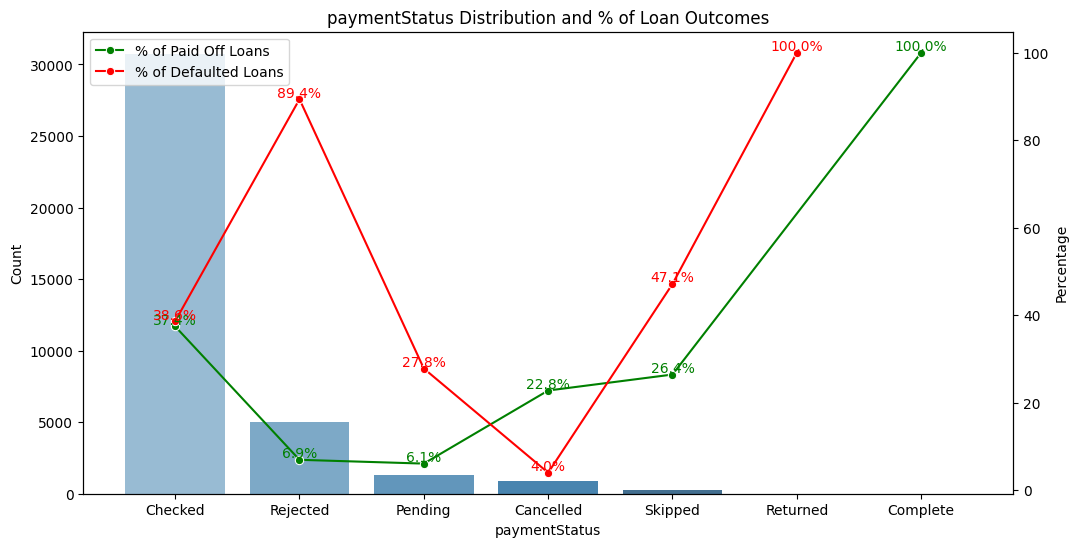

In [ ]:
plot_distribution_vs_loan_outcomes(df,'paymentStatus')

This plot provides insights into the distribution of loan outcomes based on the `paymentStatus`, which reflects the success or failure of payment attempts

### 1. **Checked (Payment Successful):**
   - **High Volume, Balanced Outcomes:**
     - **Count:** The "Checked" status, which indicates successful payments, has the highest count with over 30,000 instances.
     - **Default Rate:** The default rate is 39.8%, which is significant given the high volume.
     - **Paid Off Rate:** The paid off rate is also high at 39.8%, indicating that a large portion of loans with successful payments are also successfully repaid.

   - **Inference:** Successful payments are crucial for loan performance. The nearly equal percentage of paid off and defaulted loans suggests that while successful payments are a good indicator of loan performance, other factors may also contribute to defaults.

### 2. **Rejected (Payment Unsuccessful):**
   - **Moderate Volume, High Default Risk:**
     - **Count:** The "Rejected" status, indicating unsuccessful payments, has a moderate count.
     - **Default Rate:** The default rate is extremely high at 89.4%, indicating a strong correlation between unsuccessful payments and loan defaults.
     - **Paid Off Rate:** The paid off rate is very low at 6.9%, which suggests that once a payment is rejected, the likelihood of loan repayment diminishes significantly.

   - **Inference:** Unsuccessful payments are a strong predictor of loan defaults. Loans with rejected payments are at a high risk of default, and this status may require immediate intervention to prevent defaults.

### 3. **Pending (Payment Awaiting Confirmation):**
   - **Low Volume, Uncertain Outcomes:**
     - **Count:** The "Pending" status has a low count.
     - **Default Rate:** The default rate is 27.8%, which is moderate.
     - **Paid Off Rate:** The paid off rate is 6.1%, suggesting uncertainty in the outcomes of loans with pending payments.

   - **Inference:** Loans with pending payments are in a state of uncertainty. The moderate default rate indicates that some loans might eventually be successful, but the low paid off rate suggests that many of these loans may still face challenges.

### 4. **Cancelled (Payment Cancelled):**
   - **Low Volume, High Risk:**
     - **Count:** The "Cancelled" status has a low count.
     - **Default Rate:** The default rate is high at 40.0%.
     - **Paid Off Rate:** The paid off rate is 22.8%, which is relatively low.

   - **Inference:** Cancelled payments are associated with a high risk of default. Once a payment is cancelled, the likelihood of successful loan repayment decreases, suggesting that cancelled payments should be closely monitored.

### 5. **Skipped (Payment Skipped):**
   - **Low Volume, Moderate Outcomes:**
     - **Count:** The "Skipped" status has a low count.
     - **Default Rate:** The default rate is 47.2%, indicating a high risk of default.
     - **Paid Off Rate:** The paid off rate is 26.4%, showing that while some loans are eventually repaid, a significant portion still defaults.

   - **Inference:** Skipped payments are another indicator of potential risk. While some loans recover, nearly half still end up in default, suggesting that missed payments are a warning sign.

### 6. **Returned and Complete:**
   - **Very Low Volume, Positive Outcomes:**
     - **Count:** Both "Returned" and "Complete" statuses have very low counts.
     - **Default Rate:** Both statuses have a 100% default or paid off rate, respectively.
     - **Paid Off Rate:** "Complete" has a 100% paid off rate, while "Returned" has a 100% default rate.

   - **Inference:** Loans that reach the "Complete" status are always paid off, indicating successful loan performance. Conversely, "Returned" loans are always defaulted, indicating that once a loan reaches this status, recovery is unlikely.

### **Overall Inferences:**
- **High-Risk Indicators:** Rejected, Skipped, and Cancelled payment statuses are strong indicators of loan default risk. These categories should be closely monitored, and loans with these statuses may require intervention to prevent defaults.
- **Positive Outcomes:** Checked and Complete payment statuses are associated with successful loan repayment. Ensuring that more loans achieve these statuses should be a focus of loan management strategies.
- **Uncertainty with Pending Payments:** Loans with pending payments are in a state of uncertainty, and outcomes can vary. Additional monitoring or support may help improve the chances of successful repayment.
- **Immediate Action:** For loans with rejected or skipped payments, immediate action should be taken to attempt recovery and prevent defaults.


This analysis highlights the importance of payment status as a key indicator of loan performance. By focusing on reducing unsuccessful and cancelled payments and supporting loans with pending payments, lenders can improve overall loan repayment rates and reduce defaults.

In [ ]:
# dfx = pd.merge(loan_df, df_payment.loc[:, ["loanId", "isCollection"]], left_on="loanId", right_on="loanId", how="left")
# # dfx['loanStatusCategory'] = merged_df['loanStatus'].apply(classify_loan_status)

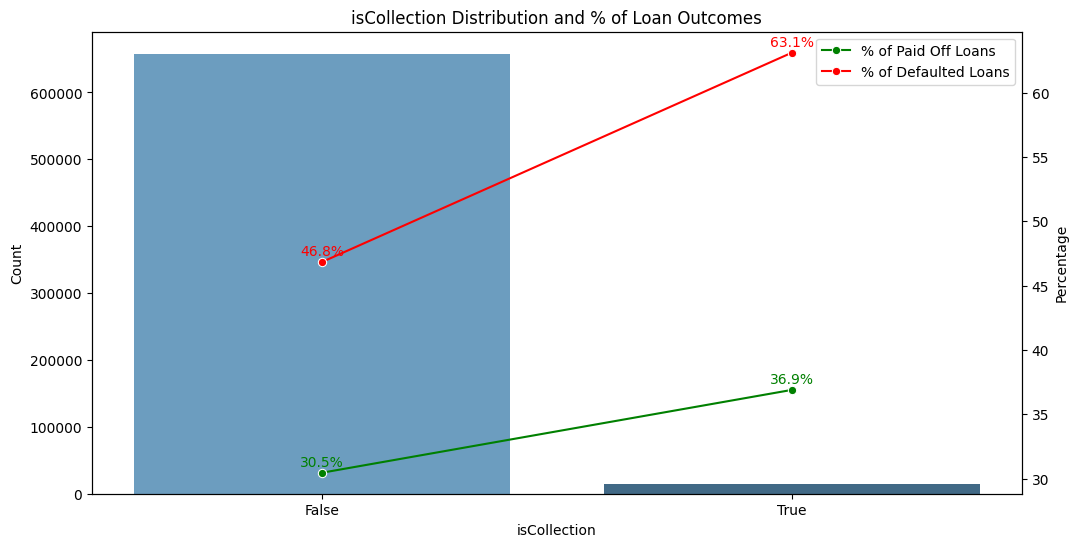

In [ ]:
# plot_distribution_vs_loan_outcomes(dfx,'isCollection')

In [ ]:
# classes = {
#     1: ["Paid Off Loan", "Settlement Paid Off",'Charged Off Paid Off'],
#     0: ["Customver Voided New Loan", "Settled Bankruptcy","Charged Off", "Customer Voided New Loan",'Settlement Pending Paid Off','External Collection', 'Internal Collection']
# }

# def map_classes(row):
#   for key, value in classes.items():
#     if row in value:
#       return key

# df['target'] = df['loanStatus'].map(map_classes)

###Business Recommendations

1. Distinct Examination of Withdrawn Applications: Withdrawn applications still provide insightful information even though they shouldn't be included in the risk prediction model. Analyzing customer withdrawals separately can reveal trends or problems with the application or approval procedure. This may highlight areas where withdrawal rates can be lowered, like through enhancing client interaction, providing more enticing conditions, or expediting the approval procedure.
Strategies for Retaining Customers: Customer retention efforts could benefit from an understanding of the causes of withdrawals. The company might provide tailored offers or incentives to keep these customers before they finish the withdrawal, for instance, if the withdrawals are the result of competitors providing better conditions.
2. Given the slight preference for higher loan amounts and scheduled payments in funded loans, the lending criteria could be refined to better target these segments, optimizing for loan profitability.
3. Incorporating borrower repayment history (nPaidOff) more prominently in the funding decision process could enhance the quality of funded loans, potentially reducing default rates and improving portfolio performance.
4. The presence of low-APR outliers in unfunded loans suggests a potential area of exploration. Understanding why these low-APR loans are not funded could reveal opportunities to adjust terms or identify risk factors not captured by APR alone.
5. The low payment success rates associated with certain loan statuses, like "CSR Voided New Loan" and "Charged Off Paid Off," indicate that these categories are high-risk. The business should focus on risk management strategies for these loan types, potentially tightening approval criteria or providing additional support for borrowers in these categories.
6. The strong correlation between loan amounts and fees in collection suggests that larger loans are at a higher risk of accruing significant fees if they enter collections. The business may want to implement early intervention strategies for higher loan amounts to prevent them from reaching the collection stage, thereby reducing the financial burden on both the borrower and the lender.
7. For loans in the "Pending Paid Off" status, where payment success rates are low, improving administrative processes or offering more flexible payment options could help increase the likelihood of successful payment completion.
8. The outliers with long approval durations suggest opportunities for process optimization, particularly for statuses like "Internal Collection" and "Rejected." Understanding why certain loans take longer to approve can help streamline the process, reducing the time to approval and potentially improving customer satisfaction.
9. Longer approval durations, especially for loans that end up in collection or are voided, could be an early indicator of potential issues. The business could implement early interventions for loans that experience delays in approval.
10. The skew towards higher payment to loan ratios may suggest that while loans are profitable due to high repayments, they could also be financially burdensome for borrowers. The business might want to review loan terms to ensure they are competitive and affordable, reducing the risk of default.
11. Understanding the distribution of this ratio can help in designing financial products that cater to different borrower segments, possibly offering more flexible repayment terms for those who might otherwise face high repayment burdens.
12. Recognizing periods of high demand can help the business allocate resources more effectively, such as ensuring sufficient staffing during peak times or targeting marketing efforts during months with historically lower applications.
13. The clear upward trend suggests that demand is likely to continue growing, which could inform capacity planning and strategic initiatives to capture this demand effectively.
14. The dips in application numbers during certain months or quarters should be investigated further. Understanding whether these are due to external factors (e.g., economic downturns) or internal issues (e.g., operational challenges) can help the business address potential weaknesses.
15. For states with extreme default rates, further investigation is warranted to identify the specific factors contributing to the high defaults. This might involve looking at local economic data, loan types offered, borrower profiles, and other relevant variables.
16. Depending on the findings, lenders might need to adjust their policies, such as altering loan terms, increasing support for at-risk borrowers, or reconsidering the types of loans offered in high-risk areas.
17. It might be useful to perform further analysis to understand the correlation between the number of fraud indicators and loan outcomes (e.g., default vs. paid off). This could help refine risk models and improve predictive accuracy.
18. Exploring how the presence of fraud indicators influences the decision to void or reject a loan could provide insights into the effectiveness of current fraud detection strategies and whether adjustments are needed.




